# Data

Using device: cpu
Using device: cpu


/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


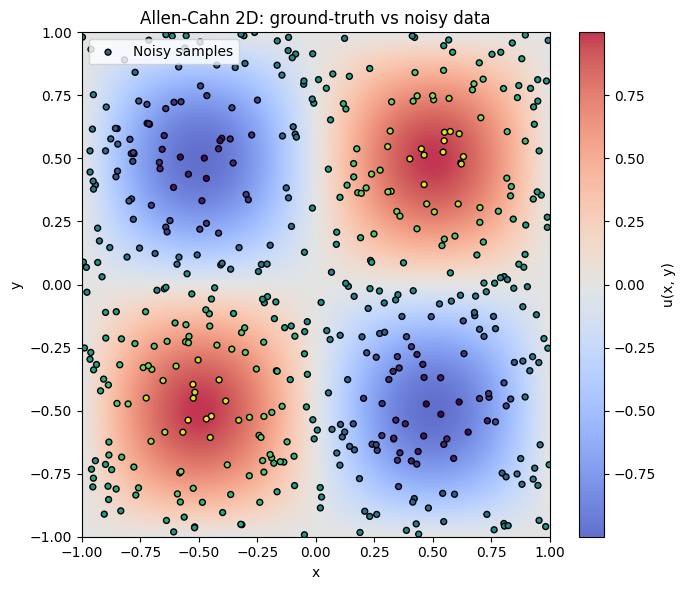

In [1]:
# ────────────────────────────────────────────────────────────────────────────────
# 0. Imports & reproducibility
# ────────────────────────────────────────────────────────────────────────────────
import math, random, numpy as np, torch
from torch import nn
# Basic
import torch
import math
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import numpy as np
from numpy import random
torch.set_num_threads(4)

# PDEi
from utils_pde.utils_pde_2dpoisson import Poisson2D

# Viz
from utils_tools.utils_result_viz import plot_predictions_2D

# Base Mdoels
from utils_uqmd.utils_uq_dropout import DropoutPINN
from utils_uqmd.utils_uq_mlp import MLPPINN
from utils_uqmd.utils_uq_vi import VIBPINN
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# CP
from utils_uqmd.utils_uq_cp import CP

torch.set_num_threads(4)
seed = 59
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# ────────────────────────────────────────────────────────────────────────────────
# 1. Ground-truth PDE setup 
# ────────────────────────────────────────────────────────────────────────────────
from utils_pde.utils_pde_allencahn2d import AllenCahn2D

# 1) keep the torch-based definition
def true_solution(xy):
    return torch.sin(math.pi*xy[...,0:1]) * torch.sin(math.pi*xy[...,1:2])

domain=((-1.0, 1.0), (-1.0, 1.0))
pde = AllenCahn2D(lam=0.05, domain=domain, true_solution=true_solution)

# ────────────────────────────────────────────────────────────────────────────────
# 2. Data Generation (Noisy data for training, test, calibration)
# ────────────────────────────────────────────────────────────────────────────────
colloc_pt_num = 250  # Number of collocation points

data_noise = 0.05
N_train = 500
N_test = 200
N_calib = 100
N_valid = 100

X_train, Y_train = pde.data_generation(N_train, data_noise)
X_test, Y_test = pde.data_generation(N_test, data_noise)
X_calibration, Y_calibration = pde.data_generation(N_calib, data_noise)
X_validation, Y_validation= pde.data_generation(N_valid, data_noise)

# Generating alphas to test
from utils_tools.utils_result_metrics import generating_alphas
alphas = generating_alphas(20)

alpha = 0.95

# ────────────────────────────────────────────────────────────────────────────────
# 3. Visualization: Plot ground-truth & noisy data
# ────────────────────────────────────────────────────────────────────────────────

def make_dense_grid(domain, N=200):
    x = np.linspace(domain[0][0], domain[0][1], N)
    y = np.linspace(domain[1][0], domain[1][1], N)
    X, Y = np.meshgrid(x, y)
    XY_grid = np.stack([X.ravel(), Y.ravel()], axis=-1)
    return XY_grid, X, Y

import matplotlib.pyplot as plt

def plot_truth_and_samples_2D(
    X_train, Y_train, grid, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
):
    fig, ax = plt.subplots(figsize=(7, 6))
    # Show the true solution as a colormap
    x = np.linspace(domain[0][0], domain[0][1], U_true_grid.shape[0])
    y = np.linspace(domain[1][0], domain[1][1], U_true_grid.shape[1])
    im = ax.imshow(
        U_true_grid,
        extent=(domain[0][0], domain[0][1], domain[1][0], domain[1][1]),
        origin='lower',
        aspect='auto',
        alpha=0.8,
        cmap='coolwarm'
    )
    # Overlay noisy training points
    ax.scatter(X_train[:,0], X_train[:,1], c=Y_train, edgecolor='k', cmap='viridis', s=18, label="Noisy samples")
    plt.colorbar(im, ax=ax, label="u(x, y)")
    ax.set_xlabel("x"); ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()


# 4) plot again
grid_test, X_mesh, Y_mesh = make_dense_grid(domain, 200)
grid_test_torch = torch.tensor(grid_test, dtype=torch.float32)
U_true_grid = true_solution(grid_test_torch).numpy().reshape(X_mesh.shape)

plot_truth_and_samples_2D(
    X_train, Y_train, grid_test, U_true_grid, domain,
    title="Allen-Cahn 2D: ground-truth vs noisy data"
)


# --------------------------------------------
# Defining Testing
# --------------------------------------------
n_grid = 100
x = torch.linspace(1.0, -1.0, n_grid)
y = torch.linspace(1.0, -1.0, n_grid)
X, Y = torch.meshgrid(x, y, indexing='xy')
grid_test = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)


# Feature Distance Model

## Define Model

In [2]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}

# CP-Model

cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"feature", # Change base on if the baseline cp
    "k":10
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":"feature",
    "n_samples":10, 
}

dist_feat_pinn = DistanceUQPINN(**model_args)

## Training Base Model

In [3]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=5000,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_feat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_feat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=10, 
    heuristic_u="feature"
)
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=1.34e+00 | lr=1.0e-03
ep   500 | L=1.79e-01 | lr=1.0e-03
ep  1000 | L=1.03e-01 | lr=1.0e-03
ep  1500 | L=8.65e-02 | lr=1.0e-03
ep  2000 | L=1.12e-01 | lr=1.0e-03
ep  2500 | L=3.62e-02 | lr=1.0e-03
ep  3000 | L=3.71e-02 | lr=1.0e-03
ep  3500 | L=3.49e-02 | lr=1.0e-03
ep  4000 | L=2.04e-02 | lr=1.0e-03
ep  4500 | L=3.61e-02 | lr=1.0e-03
ep  5000 | L=1.20e-02 | lr=1.0e-03


In [4]:
dist_feat_pinn_uncal_predset = dist_feat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)

## Create CP Model

In [5]:
# CP Model
dist_feat_pinn_cp = CP(dist_feat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"feature",  # Change this based on cp
        "k":10
}

dist_feat_pinn_cp_cal_predset = dist_feat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [6]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
dist_feat_pinn_df_uncal = dist_test_uncertainties(uqmodel=dist_feat_pinn, **baseline_testing_args)
dist_feat_pinndf_cal = cp_test_uncertainties(dist_feat_pinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage, plot_metrics_table
save_plot(
    plot_2D_comparison_with_coverage,
    save_dir="2D_AllenCahn", prefix="feature_distance",
    loss=baseline_data_loss
)(
    grid_test, dist_feat_pinn_uncal_predset, dist_feat_pinn_cp_cal_predset, 
    true_solution, 
    dist_feat_pinn_df_uncal, dist_feat_pinndf_cal,
    title="2D UQ", main_title="Feature Distance Model", 
    X_vis=X_train, Y_vis=Y_train
)

save_plot(
    plot_metrics_table,
    save_dir="2D_AllenCahn", prefix="feature_distance_table",
    loss=baseline_data_loss
)(
    grid_test, dist_feat_pinn_uncal_predset, dist_feat_pinn_cp_cal_predset, 
    true_solution, 
    dist_feat_pinn_df_uncal, dist_feat_pinndf_cal,
    title="2D UQ", main_title="Feature Distance Model", 
    X_vis=X_train, Y_vis=Y_train
)

100%|██████████| 19/19 [00:00<00:00, 488.91it/s]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Latent Distance Model

## Define Model

In [7]:
from utils_uqmd.utils_uq_distance import DistanceUQPINN

# Base-Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}

baseline_pred_kwargs = dict(n_samples=200)


# CP-Model

cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"latent", # Change base on if the baseline cp
    "k":10
}

baseline_testing_args = { 
    # "uqmodel":dist_pinn
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "heuristic_u":"latent",
    "n_samples":10, 
}

dist_lat_pinn = DistanceUQPINN(**model_args)

## Training Base Model

In [8]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=5000,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dist_lat_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dist_lat_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=10, 
    heuristic_u="latent"
)
dist_lat_pinn_uncal_predset = dist_lat_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=1.18e+00 | lr=1.0e-03
ep   500 | L=1.89e-01 | lr=1.0e-03
ep  1000 | L=6.10e-02 | lr=1.0e-03
ep  1500 | L=2.91e-02 | lr=1.0e-03
ep  2000 | L=2.67e-02 | lr=1.0e-03
ep  2500 | L=2.38e-02 | lr=1.0e-03


KeyboardInterrupt: 

## Create CP Model

In [ ]:
# CP Model
dist_lat_pinn_cp = CP(dist_lat_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"latent",  # Change this based on cp
        "k":10
}

dist_lat_pinn_cp_cal_predset = dist_lat_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
dist_lat_pinn_df_uncal = dist_test_uncertainties(uqmodel=dist_lat_pinn, **baseline_testing_args)
dist_lat_pinn_df_cal = cp_test_uncertainties(dist_lat_pinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
save_plot(
    plot_2D_comparison_with_coverage,
    save_dir="2D_AllenCahn", prefix="latent_distance",
    loss=baseline_data_loss
)(
    grid_test, dist_lat_pinn_uncal_predset, dist_lat_pinn_cp_cal_predset, 
    true_solution, 
    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal,
    title="2D UQ", main_title="Latent Distance Model", 
    X_vis=X_train, Y_vis=Y_train
)

save_plot(
    plot_metrics_table,
    save_dir="2D_AllenCahn", prefix="latent_distance_table",
    loss=baseline_data_loss
)(
    grid_test, dist_lat_pinn_uncal_predset, dist_lat_pinn_cp_cal_predset, 
    true_solution, 
    dist_lat_pinn_df_uncal, dist_lat_pinn_df_cal,
    title="2D UQ", main_title="Latent Distance Model", 
    X_vis=X_train, Y_vis=Y_train
)

100%|██████████| 19/19 [00:00<00:00, 324.61it/s]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# Dropout Model

## Define Model

In [ ]:
from utils_uqmd.utils_uq_dropout import DropoutPINN

# Base Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
}

# CP Model
cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, 
    "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline cp
    "k":10
}

cp_pred_kwargs = {
    "X_train":X_train,  "Y_train":Y_train,
    "X_cal":X_calibration, "Y_cal":Y_calibration,
    "heuristic_u":"raw_std",
    "k":10
}

baseline_testing_args = { 
    # "uqmodel":do_pinn,   # Change this
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test,
    "n_samples":20
}

dropout_pinn = DropoutPINN(**model_args)

## Training Base Model

In [ ]:
# Base Model
# Training
fit_args = dict(
    coloc_pt_num=colloc_pt_num, 
    X_train=X_train, 
    Y_train=Y_train
)
fit_kwargs_grid = dict(
    epochs=5000,
    λ_pde=1.0, λ_ic=5.0, λ_data=1.0,
    lr=1e-3, stop_schedule=20000
)
baseline_loss_dict = dropout_pinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = dropout_pinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=20
)
dropout_pinn_uncal_predset = dropout_pinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     1 | L=1.12e+00 | data=2.75e-01 | pde=5.31e-01  ic=0.00e+00  bc=3.10e-02 | lr=1.00e-03
ep   500 | L=4.14e-01 | data=1.06e-01 | pde=2.05e-01  ic=0.00e+00  bc=1.03e-02 | lr=1.00e-03
ep  1000 | L=3.05e-01 | data=7.61e-02 | pde=1.41e-01  ic=0.00e+00  bc=8.82e-03 | lr=1.00e-03
ep  1500 | L=2.60e-01 | data=6.50e-02 | pde=1.16e-01  ic=0.00e+00  bc=7.98e-03 | lr=1.00e-03
ep  2000 | L=2.74e-01 | data=6.79e-02 | pde=1.32e-01  ic=0.00e+00  bc=7.42e-03 | lr=1.00e-03
ep  2500 | L=2.37e-01 | data=5.76e-02 | pde=1.13e-01  ic=0.00e+00  bc=6.68e-03 | lr=1.00e-03
ep  3000 | L=2.19e-01 | data=5.43e-02 | pde=1.06e-01  ic=0.00e+00  bc=5.84e-03 | lr=1.00e-03
ep  3500 | L=2.08e-01 | data=5.66e-02 | pde=9.73e-02  ic=0.00e+00  bc=5.39e-03 | lr=1.00e-03
ep  4000 | L=2.00e-01 | data=4.58e-02 | pde=9.03e-02  ic=0.00e+00  bc=6.37e-03 | lr=1.00e-03
ep  4500 | L=2.06e-01 | data=4.90e-02 | pde=1.06e-01  ic=0.00e+00  bc=5.13e-03 | lr=1.00e-03
ep  5000 | L=2.07e-01 | data=5.23e-02 | pde=1.12e-01  ic=0.00e+00  bc=

/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


## Create CP Model

In [ ]:
# CP Model
dropout_pinn_cp = CP(dropout_pinn)

# Predicting
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",  # Change this based on cp
        "k":10
}

dropout_pinn_cp_cal_predset = dropout_pinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
dropout_pinn_df_uncal = do_test_uncertainties(uqmodel=dropout_pinn, **baseline_testing_args)
dropout_pinn_df_cal = cp_test_uncertainties(dropout_pinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
save_plot(
    plot_2D_comparison_with_coverage,
    save_dir="2D_AllenCahn", prefix="dropout",
    loss=baseline_data_loss
)(
    grid_test, dropout_pinn_uncal_predset, dropout_pinn_cp_cal_predset, 
    true_solution, 
    dropout_pinn_df_uncal, dropout_pinn_df_cal,
    title="2D UQ", main_title="Dropout Model", 
    X_vis=X_train, Y_vis=Y_train
)


save_plot(
    plot_metrics_table,
    save_dir="2D_AllenCahn", prefix="dropout_table",
    loss=baseline_data_loss
)(
    grid_test, dropout_pinn_uncal_predset, dropout_pinn_cp_cal_predset, 
    true_solution, 
    dropout_pinn_df_uncal, dropout_pinn_df_cal,
    title="2D UQ", main_title="Dropout Model", 
    X_vis=X_train, Y_vis=Y_train
)

100%|██████████| 19/19 [00:01<00:00, 13.22it/s]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# VI Model

## Define Model

In [ ]:
from utils_uqmd.utils_uq_vi import VIBPINN

# Base Model Instance
model_args = {
    "pde_class":pde,
    "input_dim":2,
    "hidden_dims":[16, 32, 64, 64, 64, 32, 16], 
    "output_dim":1,
    "mu_std" : 0.01, "rho" : -4, "prior_std" : 1.0, 
    "init_data_noise" : 1.0, "learn_data_noise" : False, 
    "act_func" : nn.Tanh()
}

baseline_testing_args = { 
    # "uqmodel":vi_model, 
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test
}

vi_bpinn = VIBPINN(**model_args)

## Training Base Model

In [ ]:
# Base Model
# Training
fit_args = {
    "coloc_pt_num":colloc_pt_num,
    "X_train":X_train, 
    "Y_train":Y_train
}
fit_kwargs_grid = {
    "epochs":10000,
    "λ_pde":5.0, "λ_bc":5.0, "λ_elbo":1.0,  
    "lr":3e-3,
    "stop_schedule":20000
}
baseline_loss_dict = vi_bpinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = vi_bpinn.data_loss(X_validation, Y_validation)


# Predicting
baseline_pred_kwargs = dict(
    n_samples=5000
)
vi_bpinn_uncal_predset = vi_bpinn.predict(alpha, grid_test, 
                                   **baseline_pred_kwargs)


ep     0 | L=1.27e+02 | elbo=1.25e+02 | pde=3.12e-01  ic=0.00e+00  bc=1.03e-04 | lr=3.00e-03 | learned noise_std=1.000e+00
ep     1 | L=1.27e+02 | elbo=1.25e+02 | pde=2.98e-01  ic=0.00e+00  bc=1.76e-04 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   100 | L=1.21e+02 | elbo=1.20e+02 | pde=2.58e-01  ic=0.00e+00  bc=1.08e-04 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   200 | L=1.16e+02 | elbo=1.15e+02 | pde=3.09e-01  ic=0.00e+00  bc=1.41e-04 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   300 | L=1.00e+02 | elbo=9.83e+01 | pde=3.04e-01  ic=0.00e+00  bc=4.05e-02 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   400 | L=7.66e+01 | elbo=7.56e+01 | pde=1.03e-01  ic=0.00e+00  bc=9.24e-02 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   500 | L=7.55e+01 | elbo=7.44e+01 | pde=9.94e-02  ic=0.00e+00  bc=1.15e-01 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   600 | L=7.61e+01 | elbo=7.49e+01 | pde=8.51e-02  ic=0.00e+00  bc=1.49e-01 | lr=3.00e-03 | learned noise_std=1.000e+00
ep   700 | L=8.2

## Create CP Model

In [ ]:
# CP Model
vi_bpinn_cp = CP(vi_bpinn)

# CP
cp_pred_kwargs = {
        "X_train":X_train,  "Y_train":Y_train,
        "X_cal":X_calibration, "Y_cal":Y_calibration,
        "heuristic_u":"raw_std",
        "k":10
}

cp_testing_args = {
        "alphas":alphas, 
        "X_test":X_test, "Y_test":Y_test, 
        "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
        "heuristic_u":"raw_std", # Change base on if the baseline model has its original uq band
        "k":10
}

vi_bpinn_cp_cal_predset = vi_bpinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
vi_bpinn_df_uncal = vi_test_uncertainties(uqmodel=vi_bpinn, **baseline_testing_args)
vi_bpinn_df_cal = cp_test_uncertainties(vi_bpinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
save_plot(
    plot_2D_comparison_with_coverage,
    save_dir="2D_AllenCahn", prefix="vi_bpinn",
    loss=baseline_data_loss
)(
    grid_test, vi_bpinn_uncal_predset, vi_bpinn_cp_cal_predset, 
    true_solution, 
    vi_bpinn_df_uncal, vi_bpinn_df_cal,
    title="2D UQ", main_title="VI Model", 
    X_vis=X_train, Y_vis=Y_train
)

save_plot(
    plot_metrics_table,
    save_dir="2D_AllenCahn", prefix="vi_bpinn_table",
    loss=baseline_data_loss
)(
    grid_test, vi_bpinn_uncal_predset, vi_bpinn_cp_cal_predset, 
    true_solution, 
    vi_bpinn_df_uncal, vi_bpinn_df_cal,
    title="2D UQ", main_title="VI Model",
    X_vis=X_train, Y_vis=Y_train
)

100%|██████████| 19/19 [07:31<00:00, 23.76s/it]


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

# HMC Model

## Define Model

In [ ]:
from utils_uqmd.utils_uq_hmc import HMCBPINN

# Base Model Instance
model_args = dict(
    pde_class=pde, input_dim=2, hidden_dims=[16, 32, 64, 64, 64, 32, 16],
    output_dim=1, act_func=nn.Tanh, prior_std=1.0,
    step_size=1e-3, leapfrog_steps=5
)

baseline_testing_args = {
    # "uqmodel": hmc_model,
    "alphas": alphas,
    "X_test": X_test,
    "Y_test": Y_test,
    "n_samples": 5000
}


hmc_bpinn = HMCBPINN(**model_args)

## Training Base Model

In [ ]:
# Base Model
# Training
fit_args = {
    "coloc_pt_num":colloc_pt_num,
    "X_train":X_train, 
    "Y_train":Y_train
}
fit_kwargs_grid = {
    "λ_pde": 3.0,
    "λ_bc": 5.0,
    "λ_data": 1.0,
    "epochs": 5000,
    "lr":1e-3,
    "hmc_samples": 10000,
    "brun_in":5000,
    "step_size": 5e-4,
    "leapfrog_steps": 13
}
baseline_loss_dict = hmc_bpinn.fit(**fit_args, **fit_kwargs_grid)

# Test the model performance
baseline_data_loss = hmc_bpinn.data_loss(X_validation, Y_validation)

# Predict 
baseline_pred_kwargs = {"n_samples": 5000}
hmc_bpinn_uncal_predset = hmc_bpinn.predict(
            alpha=alpha, X_test=grid,
            **baseline_pred_kwargs
        )

MAP:  10%|█         | 510/5000 [00:04<00:35, 124.81it/s, loss=9.73e-01]

[MAP] epoch    500 −logPost=1.047e+00  Data=2.46e-01  PDE=5.51e-01  IC=0.00e+00  BC=2.29e-07


MAP:  20%|██        | 1014/5000 [00:08<00:32, 122.42it/s, loss=7.37e-01]

[MAP] epoch   1000 −logPost=7.905e-01  Data=2.46e-01  PDE=5.35e-01  IC=0.00e+00  BC=3.92e-06


MAP:  30%|███       | 1522/5000 [00:12<00:29, 117.90it/s, loss=7.22e-01]

[MAP] epoch   1500 −logPost=7.854e-01  Data=2.46e-01  PDE=5.40e-01  IC=0.00e+00  BC=8.07e-07


MAP:  40%|████      | 2012/5000 [00:16<00:24, 123.60it/s, loss=7.67e-01]

[MAP] epoch   2000 −logPost=7.593e-01  Data=2.46e-01  PDE=5.14e-01  IC=0.00e+00  BC=2.99e-08


MAP:  50%|█████     | 2521/5000 [00:20<00:19, 127.20it/s, loss=7.69e-01]

[MAP] epoch   2500 −logPost=7.966e-01  Data=2.46e-01  PDE=5.51e-01  IC=0.00e+00  BC=7.68e-09


MAP:  60%|██████    | 3022/5000 [00:24<00:15, 130.96it/s, loss=7.71e-01]

[MAP] epoch   3000 −logPost=7.555e-01  Data=2.46e-01  PDE=5.10e-01  IC=0.00e+00  BC=1.18e-06


MAP:  70%|███████   | 3517/5000 [00:28<00:12, 122.34it/s, loss=7.69e-01]

[MAP] epoch   3500 −logPost=8.153e-01  Data=2.46e-01  PDE=5.70e-01  IC=0.00e+00  BC=2.79e-06


MAP:  80%|████████  | 4018/5000 [00:32<00:07, 134.18it/s, loss=7.74e-01]

[MAP] epoch   4000 −logPost=7.935e-01  Data=2.46e-01  PDE=5.48e-01  IC=0.00e+00  BC=2.31e-06


MAP:  90%|█████████ | 4523/5000 [00:36<00:03, 132.70it/s, loss=7.47e-01]

[MAP] epoch   4500 −logPost=8.132e-01  Data=2.46e-01  PDE=5.68e-01  IC=0.00e+00  BC=8.64e-09


[MAP] epoch   5000 −logPost=7.802e-01  Data=2.46e-01  PDE=5.35e-01  IC=0.00e+00  BC=2.09e-07


HMC:   5%|▌         | 502/10000 [00:43<12:29, 12.68it/s, acc=0.77]

[HMC] iter    500  acc-rate=0.77


HMC:  10%|█         | 1001/10000 [01:25<12:24, 12.09it/s, acc=0.74]

[HMC] iter   1000  acc-rate=0.74


HMC:  15%|█▌        | 1501/10000 [02:09<18:32,  7.64it/s, acc=0.74]

[HMC] iter   1500  acc-rate=0.74


HMC:  20%|██        | 2001/10000 [02:53<11:01, 12.10it/s, acc=0.75]

[HMC] iter   2000  acc-rate=0.75


HMC:  25%|██▌       | 2501/10000 [03:41<11:47, 10.60it/s, acc=0.76]

[HMC] iter   2500  acc-rate=0.76


HMC:  30%|███       | 3001/10000 [04:25<08:37, 13.53it/s, acc=0.75]

[HMC] iter   3000  acc-rate=0.76


HMC:  35%|███▌      | 3501/10000 [05:09<09:01, 11.99it/s, acc=0.75]

[HMC] iter   3500  acc-rate=0.75


HMC:  40%|████      | 4002/10000 [05:48<08:25, 11.86it/s, acc=0.76]

[HMC] iter   4000  acc-rate=0.76


HMC:  45%|████▌     | 4502/10000 [06:30<07:37, 12.01it/s, acc=0.76]

[HMC] iter   4500  acc-rate=0.76


HMC:  50%|█████     | 5002/10000 [07:12<06:48, 12.25it/s, acc=0.76]

[HMC] iter   5000  acc-rate=0.76


HMC:  55%|█████▌    | 5502/10000 [07:50<07:07, 10.53it/s, acc=0.76]

[HMC] iter   5500  acc-rate=0.76


HMC:  60%|██████    | 6001/10000 [08:32<06:33, 10.16it/s, acc=0.75]

[HMC] iter   6000  acc-rate=0.75


HMC:  65%|██████▌   | 6501/10000 [09:09<04:14, 13.77it/s, acc=0.75]

[HMC] iter   6500  acc-rate=0.75


HMC:  70%|███████   | 7001/10000 [09:48<03:40, 13.59it/s, acc=0.74]

[HMC] iter   7000  acc-rate=0.74


HMC:  75%|███████▌  | 7501/10000 [10:26<03:34, 11.67it/s, acc=0.74]

[HMC] iter   7500  acc-rate=0.74


HMC:  80%|████████  | 8002/10000 [11:03<02:27, 13.56it/s, acc=0.73]

[HMC] iter   8000  acc-rate=0.73


HMC:  85%|████████▌ | 8502/10000 [11:41<01:38, 15.24it/s, acc=0.73]

[HMC] iter   8500  acc-rate=0.73


HMC:  90%|█████████ | 9002/10000 [12:17<01:19, 12.54it/s, acc=0.72]

[HMC] iter   9000  acc-rate=0.72


HMC:  95%|█████████▌| 9502/10000 [12:57<00:36, 13.53it/s, acc=0.72]

[HMC] iter   9500  acc-rate=0.72


[HMC] iter  10000  acc-rate=0.72
Finished HMC: avg acceptance 0.720
Kept 9500 posterior samples


NameError: name 'grid' is not defined

## Create CP Model

In [ ]:
# CP Model
hmc_bpinn_cp = CP(hmc_bpinn)

# CP
cp_pred_kwargs = { 
    "X_train": X_train, "Y_train": Y_train,
    "X_cal": X_calibration, "Y_cal": Y_calibration,
    "heuristic_u": "raw_std", "k": 10
}

cp_testing_args = {
    "alphas":alphas, 
    "X_test":X_test, "Y_test":Y_test, 
    "X_cal":X_calibration, "Y_cal":Y_calibration, "X_train":X_train, "Y_train":Y_train, 
    "heuristic_u":"raw_std", # Change base on if the baseline model has its original uq band
    "k":10
}

hmc_bpinn_cp_cal_predset = hmc_bpinn_cp.predict(
        alpha=alpha, X_test=grid_test,
        **cp_pred_kwargs
)

## Plot Coverage Plot

In [ ]:
# Computing Coverage Info
from utils_tools.utils_result_metrics import hmc_test_uncertainties, cp_test_uncertainties, vi_test_uncertainties, do_test_uncertainties, dist_test_uncertainties
hmc_bpinn_df_uncal = hmc_test_uncertainties(uqmodel=hmc_bpinn, **baseline_testing_args)
hmc_bpinn_df_cal = cp_test_uncertainties(hmc_bpinn_cp, **cp_testing_args)

# Save the plot
from utils_tools.utils_tuning import save_plot
from utils_tools.utils_result_viz import plot_2D_comparison_with_coverage
save_plot(
    plot_2D_comparison_with_coverage,
    save_dir="2D_AllenCahn", prefix="hmc_bpinn",
    loss=baseline_data_loss
)(
    grid_test, hmc_bpinn_uncal_predset, hmc_bpinn_cp_cal_predset, 
    true_solution, 
    hmc_bpinn_df_uncal, hmc_bpinn_df_cal,
    title="2D UQ", main_title="HMC Model", 
    X_vis=X_train, Y_vis=Y_train
)

save_plot(
    plot_metrics_table,
    save_dir="2D_AllenCahn", prefix="hmc_bpinn_table",
    loss=baseline_data_loss
)(
    grid_test, hmc_bpinn_uncal_predset, hmc_bpinn_cp_cal_predset, 
    true_solution, 
    hmc_bpinn_df_uncal, hmc_bpinn_df_cal,
    title="2D UQ", main_title="HMC Model", 
    X_vis=X_train, Y_vis=Y_train
)

  0%|          | 0/19 [00:00<?, ?it/s]/Users/yifanyu/miniconda3/envs/cp/lib/python3.10/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
100%|██████████| 19/19 [00:59<00:00,  3.12s/it]


<Figure size 640x480 with 0 Axes>